In [1]:
!pip install retry-requests
!pip install requests-cache
!pip install openmeteo-requests

  Using cached openmeteo_requests-1.3.0-py3-none-any.whl.metadata (9.7 kB)
  Using cached openmeteo_sdk-1.14.1-py3-none-any.whl.metadata (934 bytes)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
Using cached openmeteo_requests-1.3.0-py3-none-any.whl (6.0 kB)
Using cached openmeteo_sdk-1.14.1-py3-none-any.whl (7.3 kB)
Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
from pprint import pprint
from retry_requests import retry
import requests_cache
import openmeteo_requests

In [4]:
with open('descriptions.json', 'r') as f:
    data = json.load(f)
# Accessing data
code = ['weather_code']

#data[code]['day']["description"]
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 39.0376,
	"longitude": -77.4158,
	"start_date": "2000-01-01",
	"end_date": "2008-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "weather_code", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"],
	"daily": "weather_code",
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch",
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(7).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(8).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(9).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(10).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(11).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(12).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(13).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(14).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(15).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(16).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(17).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(18).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["weather_code"] = hourly_weather_code.astype(int)
hourly_data["pressure_msl"] = hourly_pressure_msl
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
#print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code

daily_dataframe = pd.DataFrame(data = daily_data)
hourly_dataframe.head()

Coordinates 39.05096435546875°N -77.40740966796875°E
Elevation 101.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,2000-01-01 04:00:00+00:00,36.844700,84.508644,31.711010,0.0,0.0,0.0,0.0,0,1022.900024,1010.199524,0.0,0.0,0.0,0.0,3.325540,4.161060,250.346085,216.253922,3.8029
1,2000-01-01 05:00:00+00:00,36.214699,84.774651,30.907288,0.0,0.0,0.0,0.0,0,1022.799988,1010.084900,0.0,0.0,0.0,0.0,3.537008,4.803042,251.564957,207.758453,3.8029
2,2000-01-01 06:00:00+00:00,36.034698,84.456161,30.554066,0.0,0.0,0.0,0.0,0,1023.000000,1010.277649,0.0,0.0,0.0,0.0,3.848680,6.085298,234.462234,197.102814,4.6977
3,2000-01-01 07:00:00+00:00,32.704700,90.322327,26.706497,0.0,0.0,0.0,0.0,0,1022.700012,1009.896057,0.0,0.0,0.0,0.0,4.501876,8.325127,206.564987,186.170074,6.9347
4,2000-01-01 08:00:00+00:00,30.364700,93.612801,24.137669,0.0,0.0,0.0,0.0,0,1023.099976,1010.230469,0.0,0.0,0.0,0.0,4.562603,10.997762,191.309891,184.666779,7.3821


In [4]:
#This will change the weather code in (hourly_dataframe, cell above this) with what the weather actually was. Then condense the file to have fewer columns. 
#This will take approximately 5:30 seconds to complete. I saved it to a CSV file so that i don't need to run it every time.
#----------------------------------------------------------------------------------------------------------------------------------------------------------
clean_data = hourly_dataframe.rename(columns={'date': "Date", 'relative_humidity_2m':"Relative Humidity", 'wind_speed_100m': "Wind Speed at 100m",'wind_speed_10m': "Wind Speed at 10m",'wind_gusts_10m': "Wind Gusts at 10m",'apparent_temperature':"Temperature",'precipitation': "Precipitation",'rain':"Rain Fall",'snowfall': "Snow Fall",'snow_depth':"Amount of Snow",'weather_code':"Weather"})
#clean_data = clean_data[['Date','Temperature','Precipitation', 'Rain Fall', 'Snow Fall', 'Amount of Snow', 'Weather']]
clean_data = pd.DataFrame(clean_data)


def weather(code):
    with open('descriptions.json', 'r') as f:
        data = json.load(f)
    code = f"{code}"
    data=data[code]['day']["description"]
    return data
for code in clean_data['Weather']:
    data = weather(code)
    clean_data['Weather'] = clean_data['Weather'].replace(to_replace=code, value=data, regex=True)

clean_data
clean_data.to_csv('weather_by_hour.csv') 

In [12]:
from io import StringIO

airline_df = Path('../module_7_project_1/airlines_2000_2008_iad_origin.csv')
carriers_df = ('../module_7_project_1/carriers.csv')
weather_df = Path('weather_by_hour.csv')

airline_df = pd.read_csv(airline_df)
weather_df = pd.read_csv(weather_df)
df.head()

,ActualElapsedTime,AirTime,ArrDelay,ArrTime,CRSArrTime,CRSDepTime,CRSElapsedTime,CancellationCode,Cancelled,CarrierDelay,...,Month,NASDelay,Origin,SecurityDelay,TailNum,TaxiIn,TaxiOut,UniqueCarrier,WeatherDelay,Year
0,86.0,70.0,-23.0,1346.0,1409,1230,99.0,NaN,0,0.0,...,3,0.0,IAD,0.0,N680BR,4.0,11.0,DH,0.0,2004
1,130.0,69.0,41.0,2033.0,1952,1805,107.0,NaN,0,0.0,...,9,23.0,IAD,0.0,N814CA,2.0,59.0,OH,18.0,2004
2,324.0,299.0,-24.0,1957.0,2021,1736,345.0,NaN,0,NaN,...,10,NaN,IAD,NaN,N583UA,6.0,19.0,UA,NaN,2008
3,72.0,50.0,-11.0,1353.0,1404,1245,79.0,NaN,0,0.0,...,6,0.0,IAD,0.0,N691BR,3.0,19.0,DH,0.0,2004
4,53.0,39.0,-11.0,806.0,817,715,62.0,NaN,0,0.0,...,10,0.0,IAD,0.0,N319UE,5.0,8.0,DH,0.0,2003


In [13]:
#code changes the value in the "Month", "Year", 'DayofMonth' and the Departure time to an integer to get the formatting of (2009-01-01 03:00:00+00:00)
#this will take approximately 40 seconds to complete.
#--------------------------------------------------------------------------------------------------------------------------------------------------

conair_df = airline_df[["Month", "Year", 'DayofMonth']].astype(int)
dep_df = airline_df['DepTime'].round(-2)

dep_df = pd.DataFrame(dep_df)

conair_df['Departure'] = dep_df['DepTime']
conair_df = conair_df.fillna(0)
conair_df['Departure'] = conair_df["Departure"].astype(int)
i = 0
airline_date = []
for index, row in conair_df.iterrows():
 
    i = i + 1
    month = row["Month"]
    day = row["DayofMonth"]
    year = row["Year"]
    time = row["Departure"]/100
    if month < 10:
        month = f'0{month}'
    if day < 10:
        day = f'0{day}'
    if time < 10:
        time = f'0{int(time)}'
    else:
        time = f'{int(time)}'
    airline_date.append(f'{year}-{month}-{day} {time}:00:00+00:00')    
    #if i == 15:
        #break  
    

airline_df.insert(2, "Date", airline_date, True)

airline_df.head()
airline_df.to_csv('date_format.csv') 

In [14]:
#This brings in the complete.csv file then merges it with the updated weather codes to officially generating the final draft of the dataframe/csv file
#This will take about 15 seconds to complete
#----------------------------------------------------------------------------------------------------
complete_df = Path('date_format.csv')
complete_df = pd.read_csv(complete_df)

complete_df = complete_df.merge(weather_df, how='left', on='Date')
complete_df
complete_df = complete_df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
complete_df.to_csv('final_df.csv') 

In [15]:
carriers_df = pd.read_csv(carriers_df)

carriers_df

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1486,ZW,Air Wisconsin Airlines Corp
1487,ZX,Air Georgian
1488,ZX (1),Airbc Ltd.
1489,ZY,Atlantic Gulf Airlines


In [16]:
# Filter by UniqueCarrier, Year, and Month
filtered_df = airline_df[['UniqueCarrier', 'Year', 'Month']]

# Sort by Year in ascending order
filtered_df_sorted = filtered_df.sort_values(by=['Year', 'Month'])

# Create a new DataFrame with the filtered and sorted data
new_df = filtered_df_sorted.reset_index(drop=True)

# Display the first few rows of the new DataFrame
new_df

,UniqueCarrier,Year,Month
0,NW,2000,1
1,US,2000,1
2,NW,2000,1
3,UA,2000,1
4,UA,2000,1
...,...,...,...
786375,UA,2008,12
786376,UA,2008,12
786377,YV,2008,12
786378,UA,2008,12


In [17]:
# Group by Year and UniqueCarrier, then count the occurrences
carrier_counts = filtered_df.groupby(['Year', 'UniqueCarrier']).size().reset_index(name='Count')

# For each year, find the UniqueCarrier with the maximum count
most_used_carrier_per_year = carrier_counts.loc[carrier_counts.groupby('Year')['Count'].idxmax()]

most_used_carrier_per_year

,Year,UniqueCarrier,Count
6,2000,UA,34976
14,2001,UA,32317
23,2002,UA,23069
29,2003,DH,55173
43,2004,DH,76000
58,2005,DH,66579
83,2006,YV,38469
99,2007,YV,30750
109,2008,UA,25807


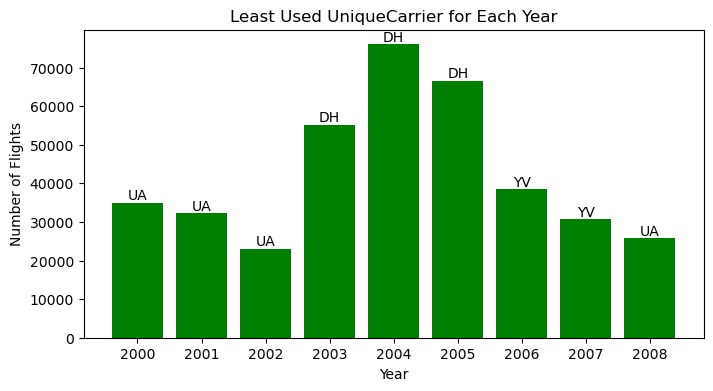

In [18]:
# Plotting the bar chart
plt.figure(figsize=(8, 4))
bars = plt.bar(most_used_carrier_per_year['Year'], most_used_carrier_per_year['Count'], color='green')
plt.xticks(most_used_carrier_per_year['Year'])
plt.xlabel('Year')
plt.ylabel('Number of Flights')
plt.title('Least Used UniqueCarrier for Each Year')

# Add the carrier name on top of each bar
for bar, carrier in zip(bars, most_used_carrier_per_year['UniqueCarrier']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, carrier, ha='center', va='bottom', fontsize=10)


plt.show()

In [19]:
# Group by Year and UniqueCarrier, then count the occurrences
carrier_counts = filtered_df.groupby(['Year', 'UniqueCarrier']).size().reset_index(name='Count')

# For each year, find the UniqueCarrier with the maximum count
most_used_carrier_per_year = carrier_counts.loc[carrier_counts.groupby('Year')['Count'].idxmax()]

# Combine the counts of the most used carriers across all years
top_carrier_combined = most_used_carrier_per_year.groupby('UniqueCarrier')['Count'].sum().reset_index()

top_carrier_combined

,UniqueCarrier,Count
0,DH,197752
1,UA,116169
2,YV,69219


In [20]:
# Most used carrier name based on their code
filtered_df = carriers_df[carriers_df['Code'].isin(['DH', 'YV', 'UA'])]
filtered_df

,Code,Description
434,DH,Independence Air
1297,UA,United Air Lines Inc.
1465,YV,Mesa Airlines Inc.


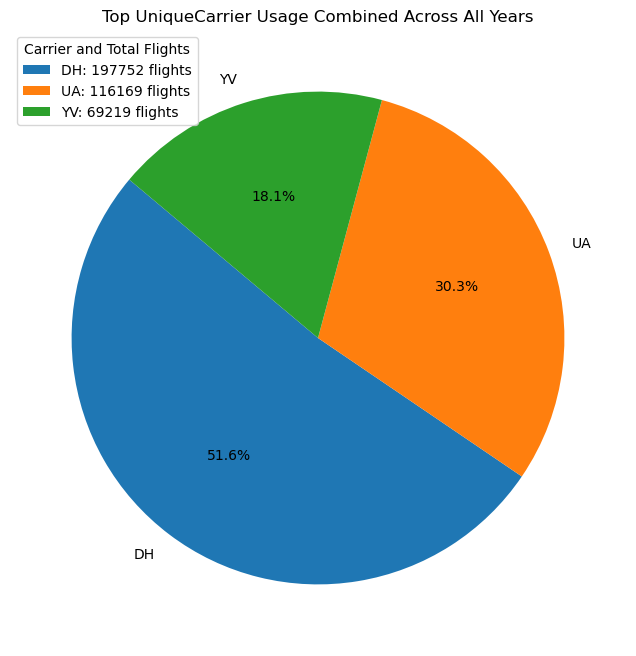

In [21]:
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_carrier_combined['Count'], labels=top_carrier_combined['UniqueCarrier'], autopct='%1.1f%%', startangle=140)
plt.title('Top UniqueCarrier Usage Combined Across All Years')
# Prepare the legend information
labels = [f"{carrier}: {count} flights" for carrier, count in zip(top_carrier_combined['UniqueCarrier'], top_carrier_combined['Count'])]

# Add a legend with the carrier names and their total flight numbers
plt.legend(labels, title="Carrier and Total Flights", loc='upper left')

plt.show()

In [25]:
# Group by Year and UniqueCarrier, then count the occurrences
carrier_counts = new_df.groupby(['Year', 'UniqueCarrier']).size().reset_index(name='Count')

# For each year, find the UniqueCarrier with the minimum count
least_used_carrier_per_year = carrier_counts.loc[carrier_counts.groupby('Year')['Count'].idxmin()]
least_used_carrier_per_year

,Year,UniqueCarrier,Count
3,2000,HP,13
11,2001,MQ,707
20,2002,HP,65
31,2003,EV,1
42,2004,CO,369
57,2005,CO,303
74,2006,EV,101
94,2007,OO,14
103,2008,CO,9


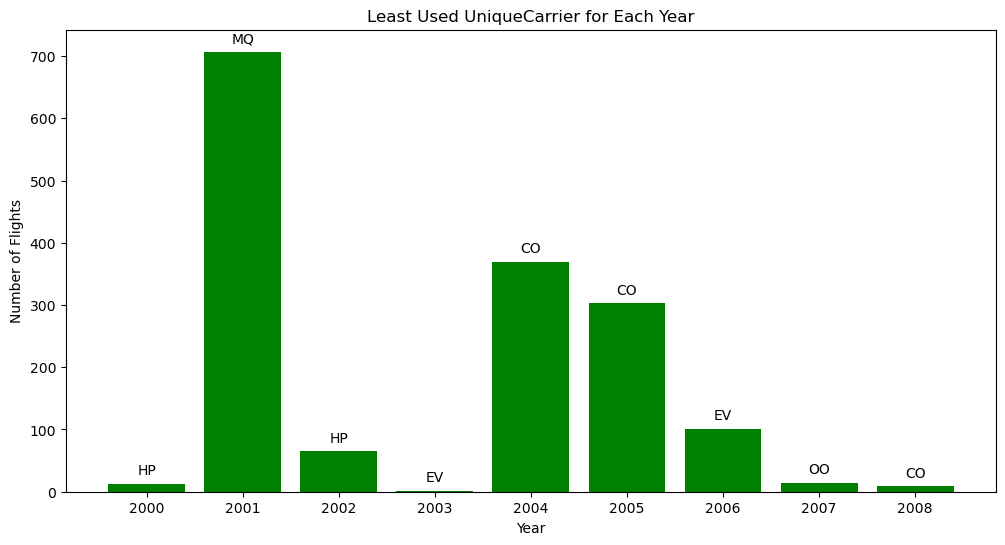

In [26]:
# bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(least_used_carrier_per_year['Year'], least_used_carrier_per_year['Count'], color='green')
plt.xticks(least_used_carrier_per_year['Year'])
plt.xlabel('Year')
plt.ylabel('Number of Flights')
plt.title('Least Used UniqueCarrier for Each Year')

# Add the carrier name on top of each bar
for bar, carrier in zip(bars, least_used_carrier_per_year['UniqueCarrier']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, carrier, ha='center', va='bottom', fontsize=10)


plt.show()

In [27]:
#least used carries name based on their code
least_carries=carriers_df[carriers_df['Code'].isin(['HP', 'MQ', 'EV', 'CO', 'OO'])]
least_carries

,Code,Description
377,CO,Continental Air Lines Inc.
505,EV,Atlantic Southeast Airlines
642,HP,America West Airlines Inc. (Merged with US Air...
848,MQ,American Eagle Airlines Inc.
949,OO,Skywest Airlines Inc.


In [28]:
# Group by Year and calculate the average number of flights for each year
total_flights_per_year = df.groupby('Year').size().reset_index(name='TotalFlights')

# Display the average number of flights per year
total_flights_per_year

,Year,TotalFlights
0,2000,65462
1,2001,54869
2,2002,44435
3,2003,103386
4,2004,132797
5,2005,122342
6,2006,96010
7,2007,91048
8,2008,76031


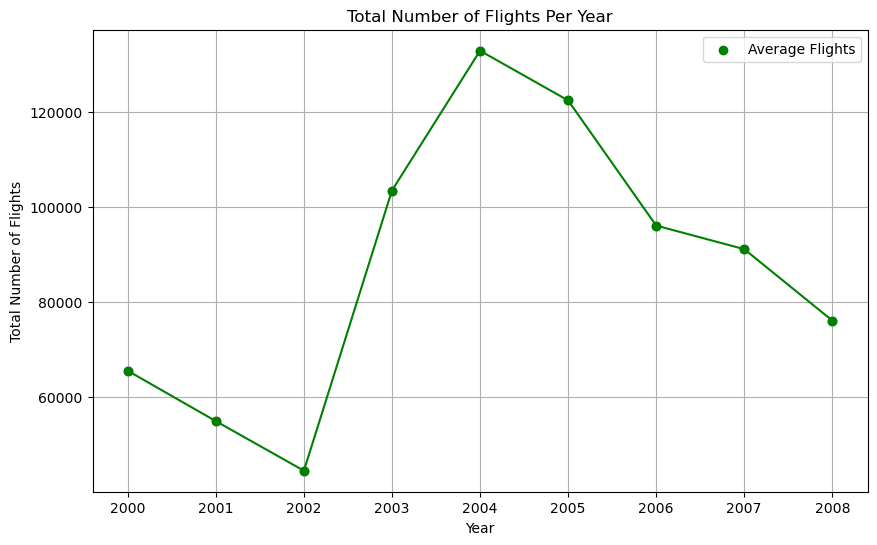

In [29]:
# Plotting the scatter plot with a connecting line
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(total_flights_per_year['Year'], total_flights_per_year['TotalFlights'], color='green', label='Average Flights')

# Line connecting the scatter points
plt.plot(total_flights_per_year['Year'], total_flights_per_year['TotalFlights'], color='green', linestyle='-', marker='o')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Total Number of Flights')
plt.title('Total Number of Flights Per Year')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

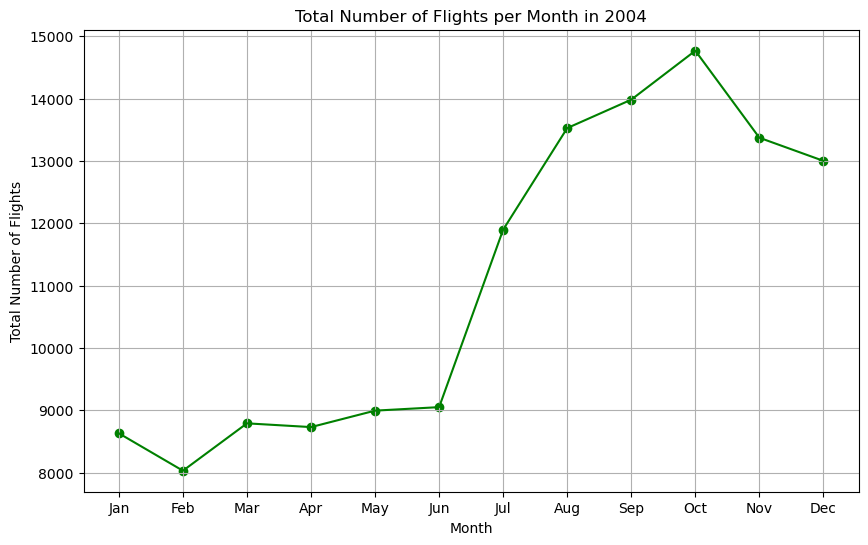

In [30]:
df_2004 = new_df[new_df['Year'] == 2004]

# Group by Month and count the number of UniqueCarrier occurrences per month
carrier_counts_per_month = df_2004.groupby('Month').size().reset_index(name='TotalFlights')


# Define the month names
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(carrier_counts_per_month['Month'], carrier_counts_per_month['TotalFlights'], color='green', label='Total Flights')

# Line plot connecting the dots
plt.plot(carrier_counts_per_month['Month'], carrier_counts_per_month['TotalFlights'], color='green')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Number of Flights')
plt.title('Total Number of Flights per Month in 2004')
plt.xticks(range(1, 13), month_names)  
plt.grid(True)

plt.show()

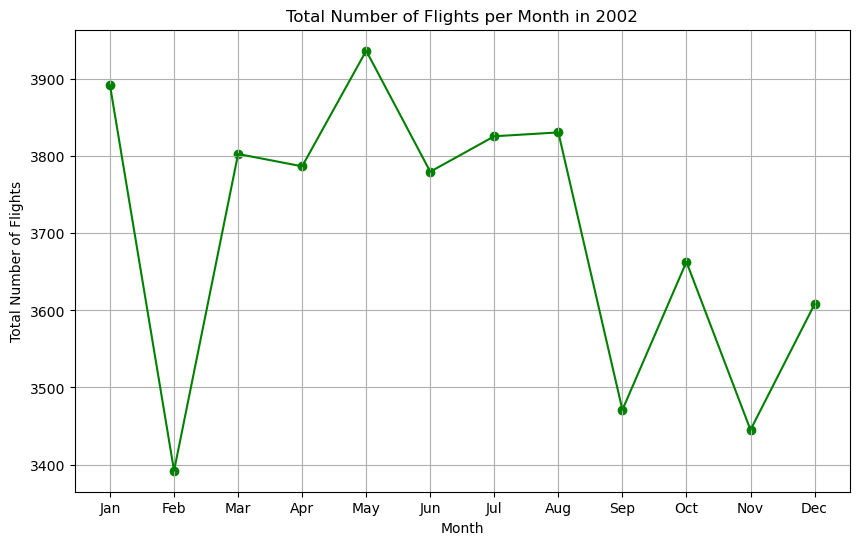

In [31]:
# Filter the data for the year 2002
df_2002 = new_df[new_df['Year'] == 2002]


# Group by Month and count the number of UniqueCarrier occurrences per month
carrier_counts_per_month2 = df_2002.groupby('Month').size().reset_index(name='TotalFlights')


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(carrier_counts_per_month2['Month'], carrier_counts_per_month2['TotalFlights'], color='green', label='Total Flights')

# Line plot connecting the dots
plt.plot(carrier_counts_per_month2['Month'], carrier_counts_per_month2['TotalFlights'], color='green')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Number of Flights')
plt.title('Total Number of Flights per Month in 2002')
plt.xticks(range(1, 13), month_names)  
plt.grid(True)

plt.show()

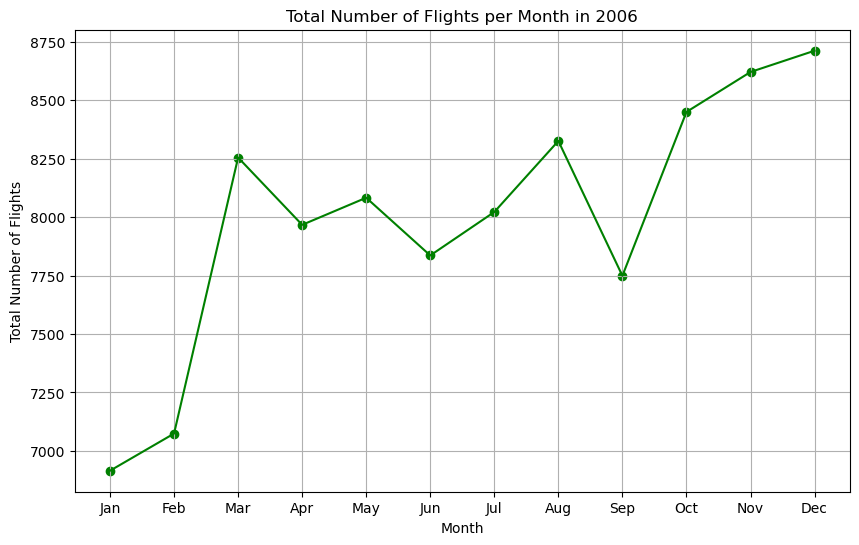

In [32]:
# Filter the data for the year 2006
df_2006 = new_df[new_df['Year'] == 2006]
# Group by Month and count the number of UniqueCarrier occurrences per month
carrier_counts_per_month3 = df_2006.groupby('Month').size().reset_index(name='TotalFlights')


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(carrier_counts_per_month3['Month'], carrier_counts_per_month3['TotalFlights'], color='green', label='Total Flights')

# Line plot connecting the dots
plt.plot(carrier_counts_per_month3['Month'], carrier_counts_per_month3['TotalFlights'], color='green')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Number of Flights')
plt.title('Total Number of Flights per Month in 2006')
plt.xticks(range(1, 13), month_names)  
plt.grid(True)

plt.show()

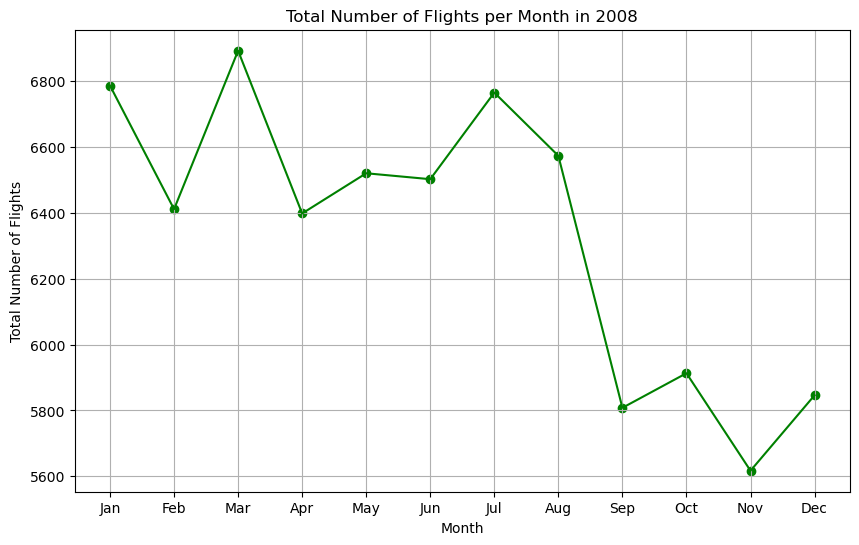

In [33]:
# Filter the data for the year 2008
df_2008 = new_df[new_df['Year'] == 2008]


# Group by Month and count the number of UniqueCarrier occurrences per month
carrier_counts_per_month4 = df_2008.groupby('Month').size().reset_index(name='TotalFlights')


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(carrier_counts_per_month4['Month'], carrier_counts_per_month4['TotalFlights'], color='green', label='Total Flights')

# Line plot connecting the dots
plt.plot(carrier_counts_per_month4['Month'], carrier_counts_per_month4['TotalFlights'], color='green')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Number of Flights')
plt.title('Total Number of Flights per Month in 2008')
plt.xticks(range(1, 13), month_names) 
plt.grid(True)

plt.show()

<Figure size 1400x800 with 0 Axes>

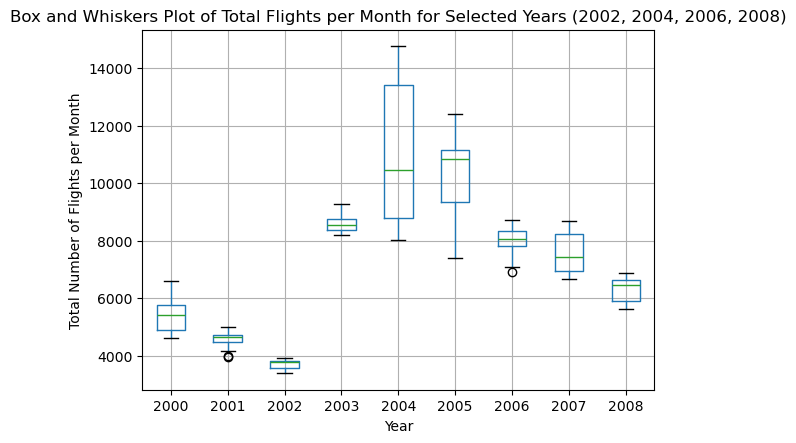

In [34]:
# Group by Year and Month, then count the number of UniqueCarrier occurrences per month
carrier_counts_per_year_month = new_df.groupby(['Year', 'Month']).size().reset_index(name='TotalFlights')

# Create a boxplot for each year to show the distribution of flights and any outliers
plt.figure(figsize=(14, 8))
carrier_counts_per_year_month.boxplot(column='TotalFlights', by='Year', grid=True, whis=1.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Number of Flights per Month')
plt.title('Box and Whiskers Plot of Total Flights per Month for Selected Years (2002, 2004, 2006, 2008)')
plt.suptitle('')  # Suppress the default title to make the custom title more prominent
plt.show()